In [1]:
import torch
import torch.nn as nn
from torch import distributions as dists
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from tqdm import tqdm

This post covers normalizing flows, and the RealNVP invertible neural network.
It's only approx 150 lines of code total.


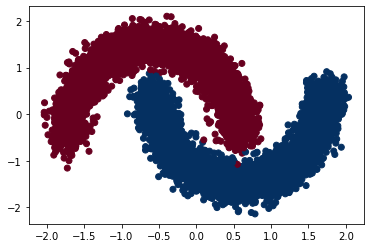

In [52]:
# Helper functions
def get_moons(n_pts=10000):
    """Get standard nonlinearly separable two-moons 2D dataset"""
    x0, y0 = make_moons(n_pts, noise=.1)
    x0 = torch.as_tensor(x0).float()
    def normalize(x):
        mu = x.mean(0, keepdims=True)
        sig = x.std(0, keepdims=True)
        return (x0-mu)/sig
    x0 = normalize(x0)
    return x0, y0

xx, yy = get_moons()
def plot_moons(xx, yy, ax):
    """Scatter plot xx and yy to matplotlib axis handle ax"""
    ax.scatter(xx[:,0], xx[:,1], c=yy, cmap="RdBu")

fig, ax = plt.subplots(1,1)
plot_moons(xx, yy, ax)

## Background

The idea of invertible networks is to learn a reversible mapping from a complicated
input (e.g. the two-moons dataset above) to a simple latent space (e.g. a standard normal
distribution).
Once the parameters of the network are learned, we can sample from the latent space
and _invert_ the transform to synthesize new examples in the input space.

The high-level picture is that the input is passed through a sequence of layers called
coupling layers; and each coupling layer is itself an arbitrarily complicated deep net.

Each coupling layer takes an input ``x`` and spits out an output ``y``,
$$y_{1:d} = x_{1:d}$$

$$y_{d+1:D} = x_{d+1:D} \circ \exp s(x_{1:d}) + t(x_{1:d})$$

We split the input/outputs each into two parts (e.g. two halves, HalfA and HalfB).
HalfA of the output is exactly HalfA of the input, without changes.
HalfB of the output is HalfB of the input, scaled and translated by arbitrary
functions ``s`` and ``t`` of HalfA of the input.

``s`` (scaling transform) and ``t`` (translating transform) can be complicated
functions, and are usually parameterized as deep nets.
The relationship between ``x`` and ``y`` in the above eqs is carefully designed to
faciliate simple Jacobian determinant computation.
The tricky part is the input splitting; which half should be HalfA and which should
be HalfB?
What the authors suggest is to _stack_ coupling layers, and alternate the splits such
 that HalfA in one layer will be HalfB in the next, and vice versa.
The original RealNVP paper does a good job at explaining the details, so I'm going to
show the code below.

## The model
The Coupling layers and full RealNVP net are detailed below, with comments.
This code is influenced by the Keras implementation.

In [32]:
class Coupling(nn.Module):
    """Two fully-connected deep nets ``s`` and ``t``, each with num_layers layers and
    The networks will expand the dimensionality up from 2D to 256D, then ultimately
    push it back down to 2D.
    """
    def __init__(self, input_dim=2, mid_channels=256, num_layers=5):
        super().__init__()
        self.input_dim = input_dim
        self.mid_channels = mid_channels
        self.num_layers = num_layers

        #  scale and translation transforms
        self.s = nn.Sequential(*self._sequential(), nn.Tanh())
        self.t = nn.Sequential(*self._sequential())

    def _sequential(self):
        """Compose sequential layers for s and t networks"""
        input_dim, mid_channels, num_layers = self.input_dim, self.mid_channels, self.num_layers
        sequence = [nn.Linear(input_dim, mid_channels), nn.ReLU()]  # first layer
        for _ in range(num_layers - 2):  # intermediate layers
            sequence.extend([nn.Linear(mid_channels, mid_channels), nn.ReLU()])
        sequence.extend([nn.Linear(mid_channels, input_dim)])  # final layer
        return sequence

    def forward(self, x):
        """outputs of s and t networks"""
        return self.s(x), self.t(x)


class RealNVP(nn.Module):
    """Creates an invertible network with ``num_coupling_layers`` coupling layers
    We model the latent space as a N(0,I) Gaussian, and compute the loss of the
    network as the negloglik in the latent space, minus the log det of the jacobian.
    The network is carefully crafted such that the logdetjac is trivially computed.
    """
    def __init__(self, num_coupling_layers):
        super().__init__()
        self.num_coupling_layers = num_coupling_layers

        # model the latent as a
        self.distribution = dists.MultivariateNormal(loc=torch.zeros(2),
                                                     covariance_matrix=torch.eye(2))
        self.masks = torch.tensor(
           [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype=torch.float32
        )

        # create num_coupling_layers layers in the RealNVP network
        self.layers_list = [Coupling() for _ in range(num_coupling_layers)]

    def forward(self, x, training=True):
        """Compute the forward or inverse transform
        The direction in which we go (input -> latent vs latent -> input) depends on
        the ``training`` param.
        """
        log_det_inv = 0.
        direction = 1
        if training:
            direction = -1

        # pass through each coupling layer (optionally in reverse)
        for i in range(self.num_coupling_layers)[::direction]:
            mask =  self.masks[i]
            x_masked = x * mask
            reversed_mask = 1. - mask
            s, t = self.layers_list[i](x_masked)
            s = s * reversed_mask
            t = t * reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * torch.exp(direction * s) + direction * t * torch.exp(gate * s))
                + x_masked
            )
            # log det (and its inverse) are easily computed
            log_det_inv = log_det_inv + gate * s.sum(1)
        return x, log_det_inv

    def log_loss(self, x):
        """log loss is the neg loglik minus the logdet"""
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -torch.mean(log_likelihood)

mdl = RealNVP(num_coupling_layers=6)

## Learning an invertible transform

With the model set up, we can now run it and try to whiten the two-moons data seen
above, then try to invert it back to the input space.

In [38]:
params = []
for l in mdl.layers_list:
    params.extend([p for p in l.parameters()])

optim = torch.optim.Adam(params, lr=.001)

losses = []

num_epochs = 3000
pbar = tqdm(range(num_epochs))
n_pts = 512
for epoch in pbar:
    x0, y0 = get_moons(n_pts=n_pts)
    loss = mdl.log_loss(x0)
    optim.zero_grad()
    loss.backward()
    optim.step()
    pbar.set_postfix({ "loss": f"{loss:.3f}"})
    losses.append(loss.detach())

## Plotting the learned transformation

I'm showing the loss below, where we can see that the network is clearly learning.

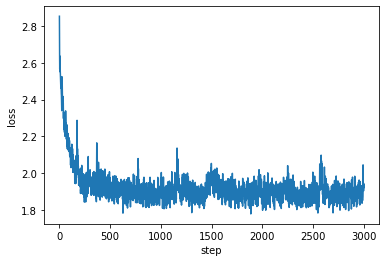

In [51]:
fig, ax = plt.subplots(1,1)
ax.plot(losses)
ax.set(xlabel="step", ylabel="loss");

Finally, we can plot what our RealNVP network has learned.
On the left we have our input data, in the middle we can see the latent space, and on
 the right we have the latent space data transformed back (i.e. inverted) to the input space.

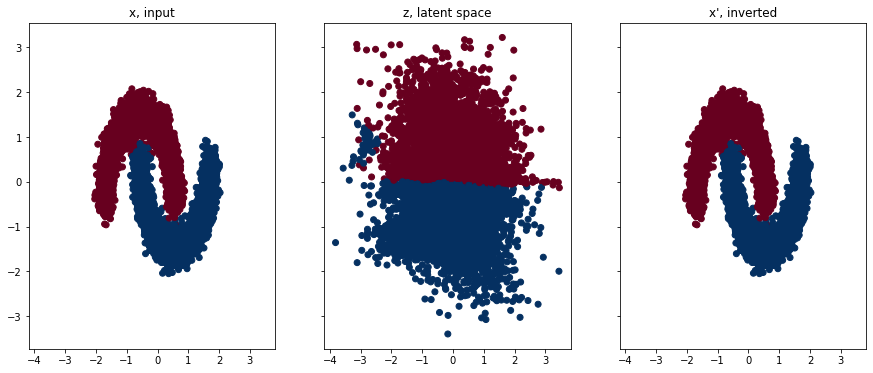

In [54]:
# map from input to latent space
x0, y0 = get_moons(n_pts=10000)
z, log_like = mdl(x0)
z = z.detach()

# map from latent back to input space
x1, _ = mdl(z, training=False)
x1 = x1.detach()

fig, ax = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(15,6))
plot_moons(x0, y0, ax[0])
plot_moons(z, y0, ax[1])
plot_moons(x1, y0, ax[2])

ax[0].set(title="x, input")
ax[1].set(title="z, latent space")
ax[2].set(title="x', inverted");
